<a href="https://colab.research.google.com/github/yeonsu-park12/weatherwise_yeonsu-park/blob/main/starter_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌦️ WeatherWise – Starter Notebook

## 🧰 Setup and Imports



In [19]:
# Install required Python libraries if they are not yet installed in the environment.
!pip install requests matplotlib pyinputplus
!pip install hands-on-ai

## 📦 Setup and Configuration

In [20]:
# Standard Library Imports
import os
import requests
import json
import re
from datetime import datetime, timedelta

# Third-Party Library Imports
import matplotlib.pyplot as plt
import pyinputplus as pyip

# 🌐 hands-on-ai Environment Variables Configuration
# Define the required server endpoint and the specific LLM model for AI communication.
os.environ['HANDS_ON_AI_SERVER'] = 'https://ollama.serveur.au'
os.environ['HANDS_ON_AI_MODEL'] = 'granite3.2'

OLLAMA_SERVER = os.environ.get('HANDS_ON_AI_SERVER')
MODEL_NAME = os.environ.get('HANDS_ON_AI_MODEL')


## 🌤️ Weather Data Functions



In [21]:
def get_weather_data(location, forecast_days=5):
    """
     [Core Function] Retrieves raw weather data for a specified location from wttr.in.

    This function uses the wttr.in JSON API (?format=j1) to fetch structured weather data.

    Args:
        location (str): The city or location name (e.g., 'Seoul').
        forecast_days (int): (Unused but kept for documentation) Number of forecast days to retrieve.

    Returns:
        dict or None: Parsed JSON weather data, or None if a network or HTTP error occurs.
    """
    # This line is present in the original structure but is overwritten immediately below.
    url = f"{OLLAMA_SERVER}/api/chat"

    # Define the correct wttr.in JSON API endpoint for data retrieval
    url = f"https://wttr.in/{location}?format=j1"

    try:
        # Request data with a timeout for resource management
        response = requests.get(url, timeout=10)
        # Raise HTTPError for bad status codes (4xx or 5xx)
        response.raise_for_status()
        data = response.json()
        return data

    except requests.exceptions.RequestException as e:
        # Handle connection errors, DNS failure, or timeout
        print(f"⚠️ Error fetching weather data for {location}: {e}")
        return None


## 📊 Visualisation Functions

In [22]:
def create_temperature_visualisation(weather_data, output_type='display'):
    """
    [Core Function] Creates a line plot of the 3-day average temperature trend.

    The function calculates the daily average temperature from the nested hourly data
    provided by the weather API.

    Args:
        weather_data (dict): The full JSON data retrieved from get_weather_data.
        output_type (str): 'display' (show plot) or 'figure' (return matplotlib object).

    Returns:
        matplotlib.figure.Figure or None: The plot figure object, or None if displayed.
    """
    if not weather_data or 'weather' not in weather_data:
        print("No weather data available for visualization.")
        return

    city = weather_data['nearest_area'][0]['areaName'][0]['value']
    dates = [day['date'] for day in weather_data['weather'][:3]]

    # Calculate daily average temperature using a nested list comprehension for aggregation
    avg_temps = [sum(int(hour['tempC']) for hour in day['hourly'])/len(day['hourly'])
                 for day in weather_data['weather'][:3]]

    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(dates, avg_temps, marker='o', linestyle='-', linewidth=2, color='red')

    # Set chart labels and visual style
    ax.set_title(f"Average Temperature Trend in {city} (Next {len(dates)} Days)")
    ax.set_xlabel("Date")
    ax.set_ylabel("Temperature (°C)")
    ax.grid(True, linestyle='--', alpha=0.6)

    if output_type == 'figure':
        return fig
    else:
        plt.show()

def create_precipitation_visualisation(weather_data, output_type='display', day_index=0):
    """
    [Core Function] Creates a dual-axis (twinx) plot showing hourly precipitation (mm)
    and the chance of rain (%).

    This uses a complex dual-axis structure to compare two metrics with different scales (0-100% vs 0-5mm).

    Args:
        weather_data (dict): The full JSON data retrieved from get_weather_data.
        output_type (str): 'display' (show plot) or 'figure' (return matplotlib object).
        day_index (int): Index of the forecast day (0=Today, 1=Tomorrow, 2=Day after tomorrow).

    Returns:
        matplotlib.figure.Figure or None: The plot figure object, or None if displayed.
    """
    if not weather_data or 'weather' not in weather_data or len(weather_data['weather']) <= day_index:
        print("No forecast data available for precipitation visualization.")
        return

    city = weather_data['nearest_area'][0]['areaName'][0]['value']
    hourly = weather_data['weather'][day_index]['hourly']

    # Format time from '600' to '06:00' for better X-axis labels
    times = [f"{int(h['time'])//100:02d}:00" for h in hourly]
    precip_mm = [float(h['precipMM']) for h in hourly]
    rain_chance_pct = [int(h['chanceofrain']) for h in hourly]

    day_label = ['Today','Tomorrow','Day After Tomorrow'][day_index]

    fig, precip_ax = plt.subplots(figsize=(8, 4))

    # --- Primary Axis (Left) for Precipitation (mm) ---
    precip_ax.plot(times, precip_mm, 'b-o', label='Precipitation (mm)')
    precip_ax.set_xlabel('Hour of Day')
    precip_ax.set_ylabel('Precipitation (mm)', color='b')
    precip_ax.tick_params(axis='y', labelcolor='b')

    # --- Secondary Axis (Right) for Chance of Rain (%) ---
    chance_ax = precip_ax.twinx()
    chance_ax.plot(times, rain_chance_pct, 'g--x', label='Chance of Rain (%)')
    chance_ax.set_ylabel('Chance of Rain (%)', color='g')
    chance_ax.tick_params(axis='y', labelcolor='g')
    chance_ax.set_ylim(0, 100)

    fig.tight_layout()
    plt.title(f"{day_label} Precipitation & Rain Chance in {city}")
    plt.grid(True, linestyle=':', alpha=0.5)

    if output_type == 'figure':
        return fig
    else:
        plt.show()


## 🤖 Natural Language Processing

In [23]:
def ask_ollama(messages: list):
    """
    [Utility Function] Communicates with the hands-on-ai server's /api/chat endpoint.

    Handles multi-turn chat messages, streams the response, and includes robust
    network and connection error checking.

    Args:
        messages (list): A list of message objects, formatted as [{"role": "user", "content": "..."}].

    Returns:
        str: The full, stripped response text from the AI, or an error message.
    """
    if not OLLAMA_SERVER or not MODEL_NAME:
        return "❌ Error: AI server or model is not configured."

    # Use the /api/chat endpoint for structured, multi-turn AI conversation
    url = f"{OLLAMA_SERVER}/api/chat"
    headers = {"Content-Type": "application/json"}
    data = {
        "model": MODEL_NAME,
        "messages": messages
    }

    try:
        response = requests.post(url, headers=headers, json=data, stream=True, timeout=30)
        response.raise_for_status()

        # Process the streaming JSON output chunk by chunk
        output = ""
        for line in response.iter_lines():
            if line:
                chunk = json.loads(line.decode("utf-8"))
                # Extract content based on the chat endpoint's streaming structure
                if "message" in chunk and "content" in chunk["message"]:
                    output += chunk["message"]["content"]
                # Stop reading when the 'done' marker is received
                if chunk.get("done", False):
                    break
        return output.strip()

    except requests.exceptions.RequestException as e:
        # Detailed error handling for network/HTTP issues
        return f"❌ Error: {response.status_code} {response.reason} for url: {url}"
    except Exception as e:
        # Catch unexpected exceptions (e.g., malformed JSON)
        return f"❌ Unexpected error in ask_ollama: {e}"


def parse_weather_question(question):
    """
    [Core Function] Parses a natural language weather question.

    This function is intended for future natural language processing (NLP) but currently
    serves as a simple data structure wrapper for the user's input.

    Args:
        question (str): The raw text input from the user.

    Returns:
        dict: A dictionary containing the user's question string.
    """
    return {"question": question}


def generate_weather_response(parsed_question, weather_data):
    """
    [Core Function] Generates a natural language response to a weather question using the AI.

    This function uses prompt engineering by combining system instructions (AI persona)
    with injected, summarized weather data to guide the LLM's output.

    Args:
        parsed_question (dict): The dictionary containing the user's processed question.
        weather_data (dict): The full JSON data retrieved from get_weather_data.

    Returns:
        str: The AI-generated natural language response.
    """
    if not weather_data:
        return "Sorry, I couldn't get the latest weather information to answer your question."

    # Summarize key data points from the raw JSON for prompt injection efficiency
    city = weather_data['nearest_area'][0]['areaName'][0]['value']
    current_temp = weather_data['current_condition'][0]['temp_C']
    current_desc = weather_data['current_condition'][0]['weatherDesc'][0]['value']

    forecast_summary = "Forecasts:\n"
    for day in weather_data['weather'][:3]:
        max_temp = day['maxtempC']
        min_temp = day['mintempC']
        # Use an hourly point (e.g., index 4, which is mid-day) for a representative description
        desc = day['hourly'][4]['weatherDesc'][0]['value']
        forecast_summary += f" - {day['date']}: Min {min_temp}°C, Max {max_temp}°C. Weather: {desc}\n"

    # 1. System Prompt: Defines the AI's role, name, and output constraints (English, data-based)
    system_prompt = "You are a friendly and helpful WeatherWise advisor named Granite. Analyze the provided weather data and user's full question. Provide a concise, natural language response based ONLY on the provided data. Respond in English."

    # 2. User Prompt: Contains all the raw data necessary for the AI to form its grounded response
    user_prompt = f"""
    [Location]: {city}
    [Current Conditions]: {current_temp}°C, {current_desc}
    [Forecast Summary (Next 3 Days)]:\n{forecast_summary}
    [User's Full Question]: {parsed_question.get('question', 'What is the weather like?')}
    """

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
    ]

    print("\n[AI Advisor is thinking...]")
    ai_response = ask_ollama(messages)

    return ai_response

## 🧭 User Interface

In [24]:
def run_app():
    """
    [Core Function] The main application loop.

    Initializes the user interface, manages the main menu navigation, and coordinates
    data fetching, visualization, and AI interaction based on user choices.
    It uses pyinputplus for validated input.

    Args:
        None

    Returns:
        None: The function runs indefinitely until the user selects the 'Exit' option.
    """
    print("="*50)
    print("🌦 WELCOME TO WEATHERWISE 🌦".center(50))
    print("="*50)

    name = input("Enter your name: ")
    city = input("Enter your initial city: ")

    while True:
        # Display the main menu options
        print("\n" + "-"*20 + " MAIN MENU " + "-"*20)
        print("1. View Temperature Trend (3-Day Chart)")
        print("2. View Precipitation & Rain Chance Graph")
        print("3. Ask Weather Question / Get AI Suggestion")
        print("4. Change City")
        print("5. Exit Application")
        print("-" * 50)

        # Use pyinputplus.inputMenu() to force a valid selection (1-5)
        choice = pyip.inputMenu(['1','2','3','4','5'], prompt="Select an option (1-5):\n", numbered=True)

        if choice == "1" or choice == "2":
            # Data fetching logic is executed for visualization options
            data = get_weather_data(city)
            if not data: continue

            if choice == "1":
                create_temperature_visualisation(data)
            elif choice == "2":
                # Validate day input (1, 2, or 3) using pyip.inputInt
                day_choice = pyip.inputInt(prompt="Select forecast day (1=Today, 2=Tomorrow, 3=Day after tomorrow): ", min=1, max=3)
                # Convert 1-based user input to 0-based list index
                create_precipitation_visualisation(data, day_index=day_choice-1)

        elif choice == "3":
            question = input("Enter your weather question: ")

            # Fetch data before calling AI to ensure fresh information
            data = get_weather_data(city)
            if not data: continue

            parsed_q = parse_weather_question(question)
            response = generate_weather_response(parsed_q, data)

            print("\n" + "="*50)
            print(f"🧠 AI Response:\n{response}")
            print("="*50)

        elif choice == "4":
            city = input("Enter new city: ")
            print(f"City changed to {city}")

        elif choice == "5":
            print(f"\nGoodbye, {name}! Stay weather-wise 🌤")
            break

        else:
            # Fallback path, though mostly prevented by pyip.inputMenu
            print("Invalid choice. Please enter a number from 1 to 5.")

## 🧩 Main Application Logic

            🌦 WELCOME TO WEATHERWISE 🌦            
Enter your name: Yeonsu Park
Enter your initial city: Seoul

-------------------- MAIN MENU --------------------
1. View Temperature Trend (3-Day Chart)
2. View Precipitation & Rain Chance Graph
3. Ask Weather Question / Get AI Suggestion
4. Change City
5. Exit Application
--------------------------------------------------
Select an option (1-5):
1. 1
2. 2
3. 3
4. 4
5. 5
1


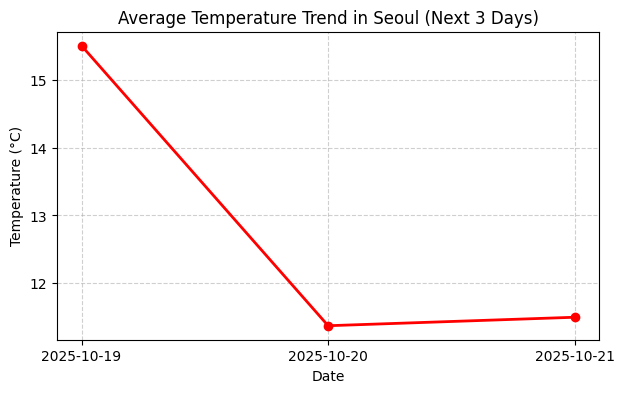


-------------------- MAIN MENU --------------------
1. View Temperature Trend (3-Day Chart)
2. View Precipitation & Rain Chance Graph
3. Ask Weather Question / Get AI Suggestion
4. Change City
5. Exit Application
--------------------------------------------------
Select an option (1-5):
1. 1
2. 2
3. 3
4. 4
5. 5
2
Select forecast day (1=Today, 2=Tomorrow, 3=Day after tomorrow): 1


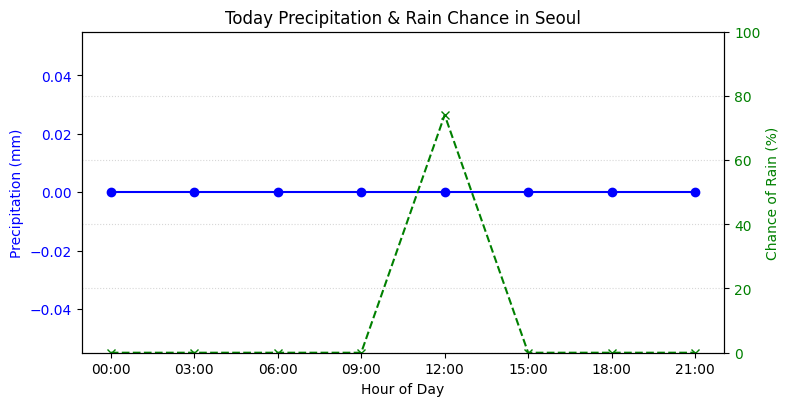


-------------------- MAIN MENU --------------------
1. View Temperature Trend (3-Day Chart)
2. View Precipitation & Rain Chance Graph
3. Ask Weather Question / Get AI Suggestion
4. Change City
5. Exit Application
--------------------------------------------------
Select an option (1-5):
1. 1
2. 2
3. 3
4. 4
5. 5
2
Select forecast day (1=Today, 2=Tomorrow, 3=Day after tomorrow): 2


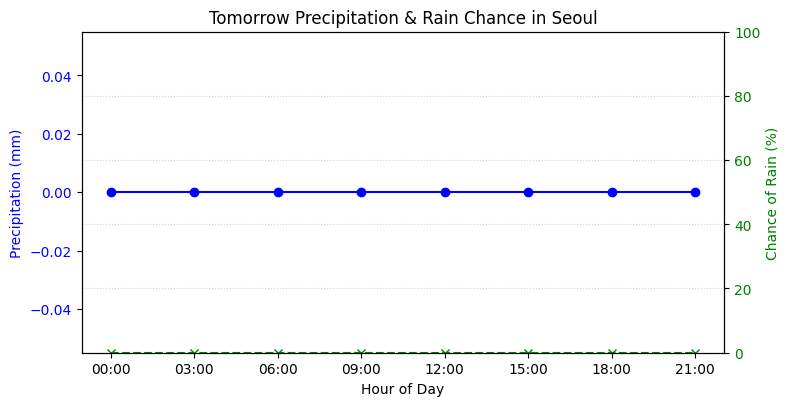


-------------------- MAIN MENU --------------------
1. View Temperature Trend (3-Day Chart)
2. View Precipitation & Rain Chance Graph
3. Ask Weather Question / Get AI Suggestion
4. Change City
5. Exit Application
--------------------------------------------------
Select an option (1-5):
1. 1
2. 2
3. 3
4. 4
5. 5
2
Select forecast day (1=Today, 2=Tomorrow, 3=Day after tomorrow): 3


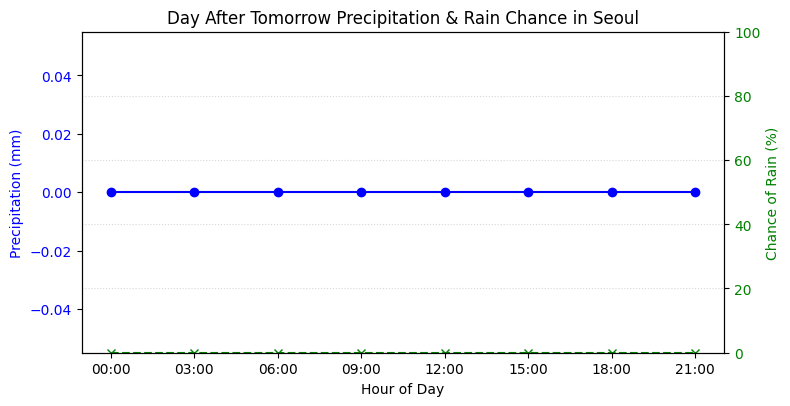


-------------------- MAIN MENU --------------------
1. View Temperature Trend (3-Day Chart)
2. View Precipitation & Rain Chance Graph
3. Ask Weather Question / Get AI Suggestion
4. Change City
5. Exit Application
--------------------------------------------------
Select an option (1-5):
1. 1
2. 2
3. 3
4. 4
5. 5
3
Enter your weather question: Can I go running tomorrow?

[AI Advisor is thinking...]

🧠 AI Response:
Based on the forecast, it's predicted to be sunny in Seoul tomorrow with a high of 15°C and low of 9°C. You should be able to go for a run without any issues related to weather conditions. Just remember to dress appropriately as it might feel cooler than usual due to the low temperatures. Enjoy your run!

-------------------- MAIN MENU --------------------
1. View Temperature Trend (3-Day Chart)
2. View Precipitation & Rain Chance Graph
3. Ask Weather Question / Get AI Suggestion
4. Change City
5. Exit Application
--------------------------------------------------
Select an op

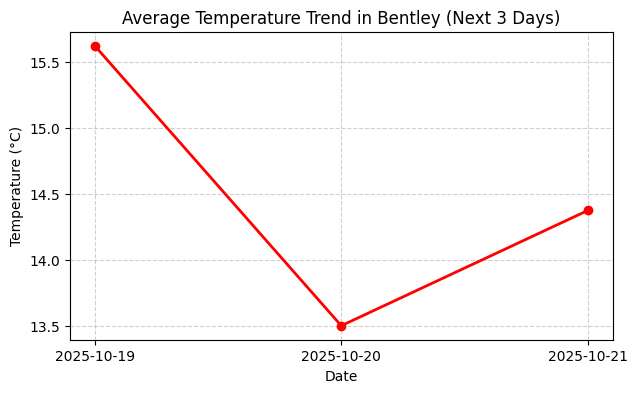


-------------------- MAIN MENU --------------------
1. View Temperature Trend (3-Day Chart)
2. View Precipitation & Rain Chance Graph
3. Ask Weather Question / Get AI Suggestion
4. Change City
5. Exit Application
--------------------------------------------------
Select an option (1-5):
1. 1
2. 2
3. 3
4. 4
5. 5
2
Select forecast day (1=Today, 2=Tomorrow, 3=Day after tomorrow): 1


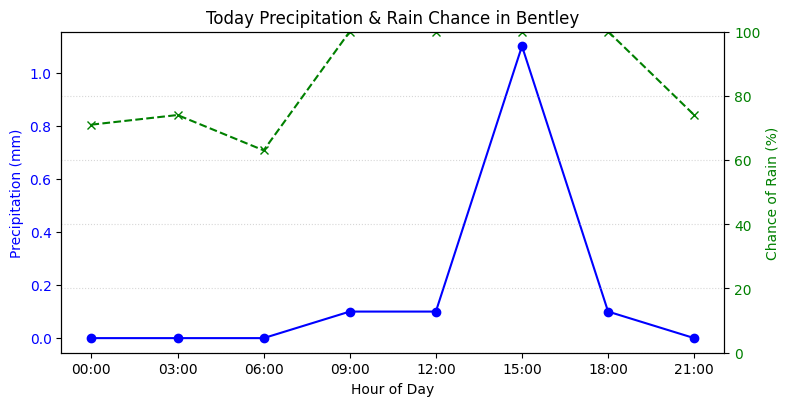


-------------------- MAIN MENU --------------------
1. View Temperature Trend (3-Day Chart)
2. View Precipitation & Rain Chance Graph
3. Ask Weather Question / Get AI Suggestion
4. Change City
5. Exit Application
--------------------------------------------------
Select an option (1-5):
1. 1
2. 2
3. 3
4. 4
5. 5
2
Select forecast day (1=Today, 2=Tomorrow, 3=Day after tomorrow): 2


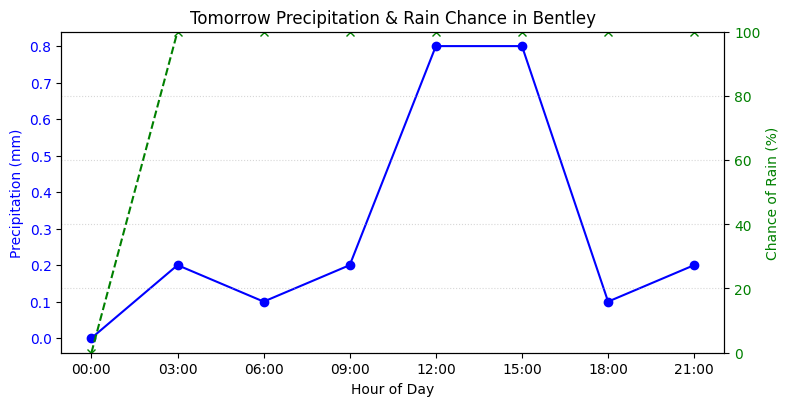


-------------------- MAIN MENU --------------------
1. View Temperature Trend (3-Day Chart)
2. View Precipitation & Rain Chance Graph
3. Ask Weather Question / Get AI Suggestion
4. Change City
5. Exit Application
--------------------------------------------------
Select an option (1-5):
1. 1
2. 2
3. 3
4. 4
5. 5
2
Select forecast day (1=Today, 2=Tomorrow, 3=Day after tomorrow): 3


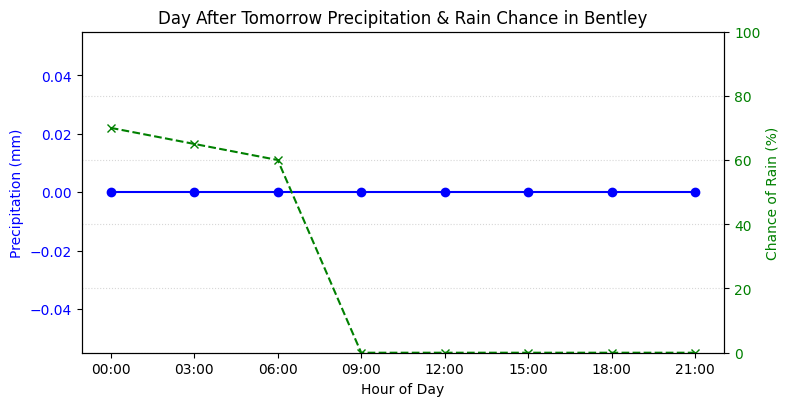


-------------------- MAIN MENU --------------------
1. View Temperature Trend (3-Day Chart)
2. View Precipitation & Rain Chance Graph
3. Ask Weather Question / Get AI Suggestion
4. Change City
5. Exit Application
--------------------------------------------------
Select an option (1-5):
1. 1
2. 2
3. 3
4. 4
5. 5
3
Enter your weather question: Should I stay in my room today?

[AI Advisor is thinking...]

🧠 AI Response:
Based on the forecast, it is expected to rain lightly throughout the day with a minimum temperature of 11°C and a maximum of 17°C. Given this information, you might want to consider carrying an umbrella if you need to go out. If not, staying indoors could be a good idea as it's likely to be wet outside.

-------------------- MAIN MENU --------------------
1. View Temperature Trend (3-Day Chart)
2. View Precipitation & Rain Chance Graph
3. Ask Weather Question / Get AI Suggestion
4. Change City
5. Exit Application
--------------------------------------------------
Select a

In [25]:
if __name__ == "__main__":
    # The entry point for execution
    run_app()

## 🧪 Testing and Examples

In [26]:
# Example prompt:
# - City: Seoul
# - Question1: Can I go running tomorrow?
# - Question2 : Should I stay in my room today?

## 🗂️ AI Prompting Log (Optional)
Add markdown cells here summarising prompts used or link to AI conversations in the `ai-conversations/` folder.